In [1]:
import av
import numpy as np
from numpy.random import randint
from time import sleep
from einops.layers.torch import Rearrange
from typing import List, Tuple
import torch
from torchvision.transforms import Compose

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

from src.opts.opts import parser
from src.utils.reproducibility import make_reproducible
from src.models.model import VideoModel
from src.dataset.video_dataset import VideoDataset
from src.dataset.video_dataset import prepare_clips_data
from src.dataset.video_transforms import GroupMultiScaleCrop, Stack, ToTorchFormatTensor, GroupRandomHorizontalFlip
from src.dataset.frame_loader import load_av_frames_from_video
from src.dataset.temporal_sampling import temporal_sampling

In [3]:
args = parser.parse_args(args=[])
args.base_model = 'InceptionV3'
args.fusion_mode = "GSF"
args.__dict__

{'holoassist_dir': '/Users/artemmerinov/data/holoassist',
 'raw_annotation_file': '/Users/artemmerinov/data/holoassist/data-annotation-trainval-v1_1.json',
 'split_dir': '/Users/artemmerinov/data/holoassist/data-splits-v1',
 'fga_map_file': '/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt',
 'base_model': 'InceptionV3',
 'fusion_mode': 'GSF',
 'num_segments': 8,
 'num_classes': 1887,
 'resume': None,
 'start_epoch': 0,
 'num_epochs': 10,
 'lr': 0.01,
 'momentum': 0.9,
 'weight_decay': 0.0005,
 'clip_gradient': None,
 'batch_size': 16,
 'num_workers': 4,
 'prefetch_factor': 2,
 'debug': False}

In [4]:
tr_video_name_arr, tr_start_arr, tr_end_arr, tr_label_arr = prepare_clips_data(
    raw_annotation_file=args.raw_annotation_file,
    holoassist_dir=args.holoassist_dir, 
    split_dir=args.split_dir,
    fga_map_file=args.fga_map_file,
    mode="train",
    task="action",
)


There are 7 videos in the split list file. 
There are 13 videos downloaded and stored on the disk 
There are 0 videos that present in the list but are missing on the disk.


In [6]:
tr_video_name_arr[123].decode(), tr_start_arr[123], tr_end_arr[123], tr_label_arr[123]

('R0027-12-GoPro', 378.588, 380.211, 38)

In [7]:
tr_video_name_arr[124].decode(), tr_start_arr[124], tr_end_arr[124], tr_label_arr[124]

('R0027-12-GoPro', 380.229, 384.804, 39)

In [8]:
tr_video_name_arr, tr_start_arr, tr_end_arr, tr_label_arr = prepare_clips_data(
    raw_annotation_file=args.raw_annotation_file,
    holoassist_dir=args.holoassist_dir, 
    split_dir=args.split_dir,
    fga_map_file=args.fga_map_file,
    mode="train",
    task="mistake",
)

There are 7 videos in the list There are 13 videos as video files There are 0 videos that present in the list but are missing as videos.


In [9]:
tr_video_name_arr[123].decode(), tr_start_arr[123], tr_end_arr[123], tr_label_arr[123]

('R0027-12-GoPro', 363.177, 380.211, 0)

In [10]:
tr_video_name_arr[124].decode(), tr_start_arr[124], tr_end_arr[124], tr_label_arr[124]

('R0027-12-GoPro', 363.177, 384.804, 0)

# Check functions

In [11]:
# Extract frames from video using start and end time. 
frames = load_av_frames_from_video(
    path_to_video="/Users/artemmerinov/data/holoassist/video_pitch_shifted/R0027-12-GoPro/Export_py/Video_pitchshift.mp4",
    start_secs=363.177, 
    end_secs=380.211,
)

In [12]:
frames

[<av.VideoFrame #201, pts=270011412 yuv420p 896x504 at 0x7f94b5047c30>,
 <av.VideoFrame #202, pts=270041805 yuv420p 896x504 at 0x7f94b5047ca0>,
 <av.VideoFrame #203, pts=270072198 yuv420p 896x504 at 0x7f94b5047d10>,
 <av.VideoFrame #204, pts=270102591 yuv420p 896x504 at 0x7f94b5047d80>,
 <av.VideoFrame #205, pts=270132984 yuv420p 896x504 at 0x7f94b5047e60>,
 <av.VideoFrame #206, pts=270163377 yuv420p 896x504 at 0x7f94b5047df0>,
 <av.VideoFrame #207, pts=270193770 yuv420p 896x504 at 0x7f94b5047f40>,
 <av.VideoFrame #208, pts=270224163 yuv420p 896x504 at 0x7f94b5047ed0>,
 <av.VideoFrame #209, pts=270254556 yuv420p 896x504 at 0x7f94b5047370>,
 <av.VideoFrame #210, pts=270284949 yuv420p 896x504 at 0x7f94b5047290>,
 <av.VideoFrame #211, pts=270315342 yuv420p 896x504 at 0x7f94b5047300>,
 <av.VideoFrame #212, pts=270345735 yuv420p 896x504 at 0x7f94b50465e0>,
 <av.VideoFrame #213, pts=270376128 yuv420p 896x504 at 0x7f94b5046500>,
 <av.VideoFrame #214, pts=270406521 yuv420p 896x504 at 0x7f94b50

In [14]:
sampling_portions, frames = temporal_sampling(
    frames=frames,
    num_segments=8,
    mode="train"
)

In [15]:
frames

[<av.VideoFrame #250, pts=271500669 yuv420p 896x504 at 0x7f94b51dcdd0>,
 <av.VideoFrame #271, pts=272138922 yuv420p 896x504 at 0x7f94b51dd700>,
 <av.VideoFrame #343, pts=274327218 yuv420p 896x504 at 0x7f94b51df680>,
 <av.VideoFrame #402, pts=276120405 yuv420p 896x504 at 0x7f94b52050e0>,
 <av.VideoFrame #413, pts=276454728 yuv420p 896x504 at 0x7f94b52055b0>,
 <av.VideoFrame #501, pts=279129312 yuv420p 896x504 at 0x7f94b5207c30>,
 <av.VideoFrame #531, pts=280041102 yuv420p 896x504 at 0x7f94b521c9e0>,
 <av.VideoFrame #584, pts=281651931 yuv420p 896x504 at 0x7f94b521e110>]

In [16]:
sampling_portions

array([0.11722488, 0.16746411, 0.33971292, 0.48086124, 0.50717703,
       0.71770335, 0.78947368, 0.91626794])

# Check entire dataloader with/without transformations

In [5]:
# Fix random state to make results reproducible
make_reproducible(random_seed=0)

tr_video_name_arr, tr_start_arr, tr_end_arr, tr_label_arr = prepare_clips_data(
    raw_annotation_file=args.raw_annotation_file,
    holoassist_dir=args.holoassist_dir, 
    split_dir=args.split_dir,
    fga_map_file=args.fga_map_file,
    mode="train",
    task="mistake",
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VideoModel(
    num_classes=args.num_classes, 
    num_segments=args.num_segments, 
    base_model=args.base_model,
    fusion_mode=args.fusion_mode,
    verbose=False,
).to(device)

input_size = model.input_size
crop_size = model.crop_size
input_mean = model.input_mean
input_std = model.input_std
div = model.div

Making reproducible on seed 0

There are 7 videos in the split list file. 
There are 13 videos downloaded and stored on the disk 
There are 0 videos that present in the list but are missing on the disk.
=> Using GSF fusion
No. of GSF modules = 11


# Without transform

In [19]:
tr_dataset = VideoDataset(
    holoassist_dir=args.holoassist_dir,
    video_name_arr=tr_video_name_arr,
    start_arr=tr_start_arr,
    end_arr=tr_end_arr,
    label_arr=tr_label_arr,
    num_segments=args.num_segments,
    transform=None,
    mode="train",
)

In [20]:
len(tr_dataset)

507

In [21]:
tr_dataset[338]

([<PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>],
 0)

In [22]:
frames, action = tr_dataset[123]

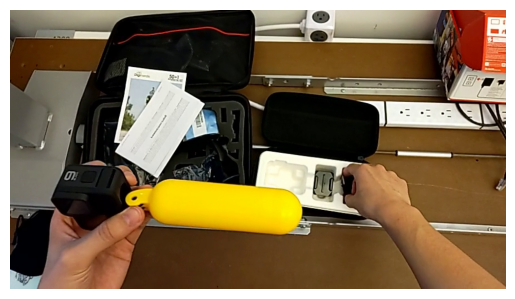

In [23]:
plt.figure()
for i in range(len(frames)):
    plt.imshow(frames[i])
    plt.axis('off')  
    plt.show()
    sleep(0.1)
    clear_output(wait=True)

# With transform

In [6]:
tr_transform = Compose([
    GroupMultiScaleCrop(crop_size, [1, .875]),
    GroupRandomHorizontalFlip(),
    Stack(roll=False),
    ToTorchFormatTensor(div=div),
    # GroupNormalize(mean=input_mean, std=input_std), # this is for model and not for visualisation
])

tr_dataset = VideoDataset(
    holoassist_dir=args.holoassist_dir,
    video_name_arr=tr_video_name_arr,
    start_arr=tr_start_arr,
    end_arr=tr_end_arr,
    label_arr=tr_label_arr,
    num_segments=args.num_segments,
    transform=tr_transform,
    mode="train",
)

In [9]:
tr_dataset[3][0].dtype

torch.float32

In [10]:
tr_dataset[3][1].dtype

dtype('int32')

In [25]:
np_frames, action = tr_dataset[2]
print(action)

np_frames = Rearrange("(t c) h w -> t c h w", c=3, t=args.num_segments, h=input_size, w=input_size)(np_frames)
print(np_frames.shape)

0
torch.Size([8, 3, 299, 299])


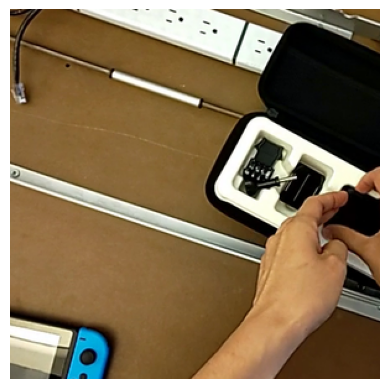

In [26]:
plt.figure()
for i in range(len(np_frames)):
    plt.imshow(np_frames[i].permute(1, 2, 0).cpu().numpy());
    plt.axis('off')  
    plt.show()
    sleep(0.1)
    clear_output(wait=True)